### Background
George Brencher

-----------------------------------------------------
This notebook is intended to provide some important background information relevant to the spicy-snow package.

## Glossary
- **synthetic aperture radar (SAR)**: An active remote sensing technique that bounces microwaves off of a target to gather information about it
- **Sentinel-1**: A constellation of synthetic aperture radar satellites launched by the European Space Agency (ESA) starting in 2014
- **passive microwave**: A passive remote sensing technique that relies on measuring microwaves emitted or reflected by a target to gather information about it
- **lidar**: An active remote sensing technique that bounces a laser off of a target to gather information about it
- **backscatter**: The microwaves returned from a target surface, which a SAR instrument measures
- **polarization**: The plane along which a wave oscillates. Sentinel-1 emits and measure microwaves in two polarizations: vertical (V) and horizontal (H)
- **C-band**: A specific group of microwave wavelengths extending from 3.75-7.5 cm
- **radiometric terrain correction (RTC)**: A method for normalizing observed SAR backscatter to terrain and removing distortions caused by SAR imaging geometry
- **forshortening**: A SAR distortion where returns from surfaces sloped towards the satellite arrive at a similar time, resulting in a bright, narrow band
- **layover**: A SAR distortion where returns from the top of a slope arrive at the same time or before returns from in front of the slope, resulting in an area of mixed or disordered signal 
- **radar shadow**: A SAR distortion where steep slopes block the radar signal from reaching behind the slope, resulting in an area where no signal is returned
- **slant range**: Distance to the sensor along the radar line-of-sight 
- **ground range**: Distance to the sensor along the ground 
- **scattering**: Redirection of the radar signal caused by interaction with some object
- **amplitude**: The strength of the returned signal

## Why snow depth with Sentinel 1?
Seasonal snow is a reservoir that provides fresh water to ecosystems, people, and hydroelectric projects as it melts. Understanding snow dynamics in a region is important both to researchers and to anyone who needs to make decisions about water management. spicy-snow implements an algorithm to retreive snow depth maps from Sentinel-1 observations with moderate temporal (1-12 days) and spatial (90-1000 m) resolution, using only a bounding box and a date range (Lievens et al., 2022). Sentinel-1 snow depth maps complement the shortcomings of other sources of snow depth measurements, including in-situ monitoring stations (point measurements, high temporal resolution), lidar (high spatial resolution, low temporal resolution), and passive microwave (low spatial resolution, variable temporal resolution). However, this approach is not a straightforward method of measuring snow depth, and significant care needs to go into correct interpretation of results. This notebook is intended to provide the necessary background to effectively understand and interpret snow depth maps from Sentinel-1 observations. 
#### Sentinel 1 orbit
As Sentinel-1 satellites travel around the Earth on their polar orbit, they observes a given location as they travels northward (ascending orbit) and back down southward (descending orbit). Flight direction will determine the time of day of the observation at a given location. This is potentially important, as snow properties may be different in the morning than in the afternoon.  

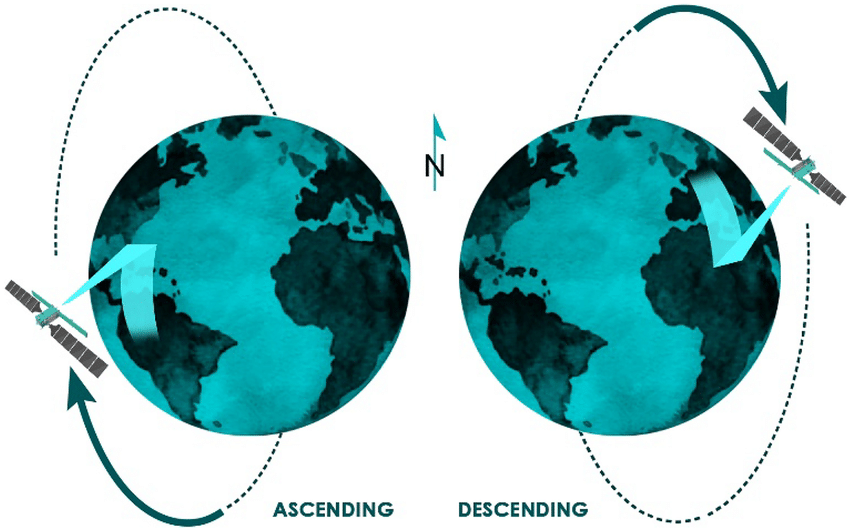

image from Pouya & Aghlmand (2022)

spicy-snow uses data collected with dual polarization (VH and VV) in interferometric wide swath (IW) mode, which has a swath width of 250 km. Frequency of Sentinel-1 data acquisition for a certain site is mostly determined by 1) the satellite operations plan, 2) the latitude of the site (typically more observations at higher latitudes) and 3) the number of satellites in operation during the period of interest. 

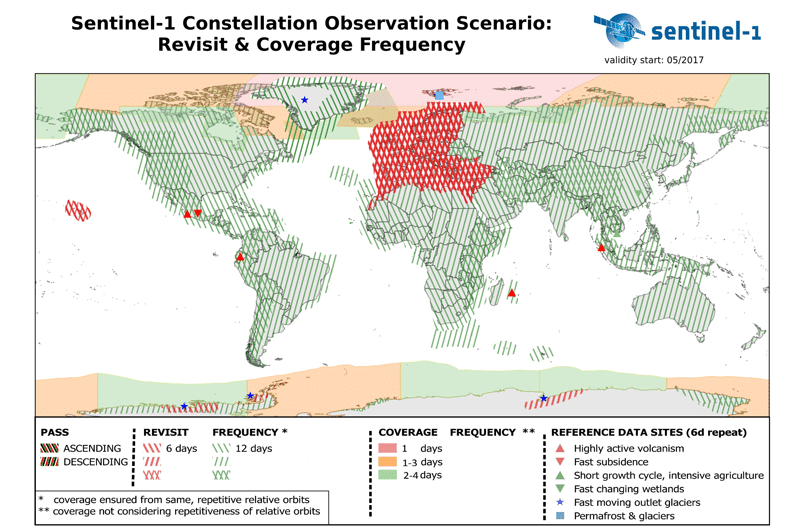

image from https://sentinel.esa.int/documents/247904/685154/Sentinel_High_Level_Operations_Plan

#### Acquisition geometry
Sentinel-1 has a side-looking veiwing geometry with incidence angles between 29.1° - 46.0° along the ground range. In practice, steep terrain results in a wide variety of incidence angles. 

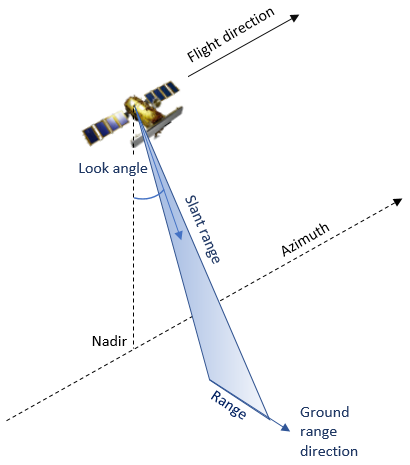

image from https://www.l3harrisgeospatial.com/docs/Sentinel1IntensityAnalysisTutorial.html 

The side-looking acquisition geometry introduces some distortions to be aware of when interpreting Sentinel-1 data, including forshortening, layover, and radar shadow. 

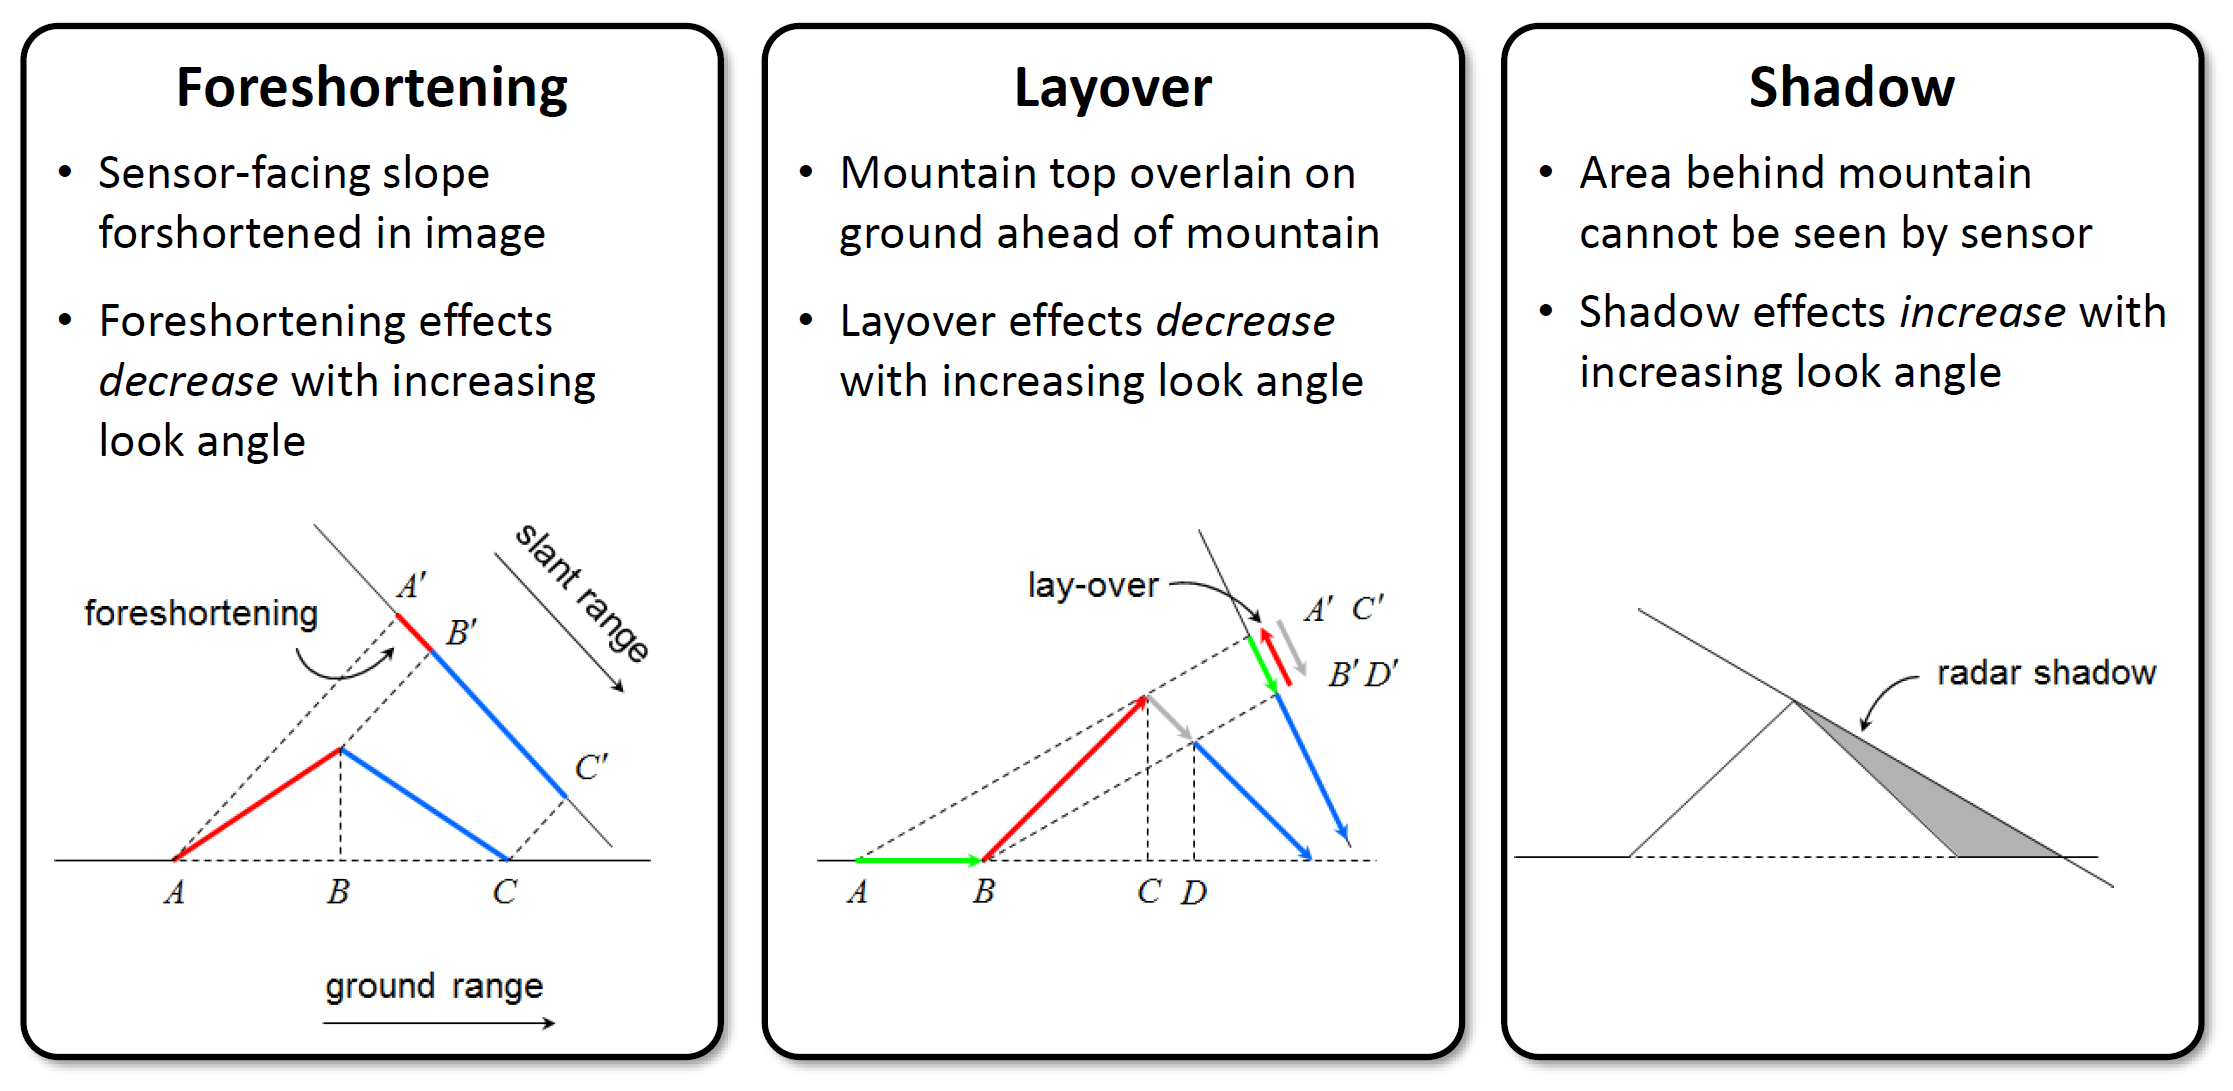

image from https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/, image credit Franz J. Meyer

Prior to producing snow maps from Sentinel 1 data, radiometric terrain correction (RTC) is employed to transform the data from slant range to ground range (to learn more about RTC, see "additional resources"). This minimizes the effects of forshortening and normalizes the amplitude of the returned signal to the slope angle. In the left image below, note that southwest-facing slopes are brighter and forshortened, while northeast-facing slopes are dimmer and lengthened. On the right image below, note that the RTC mitigates these effects. This process involves using a digital elevation model (DEM).

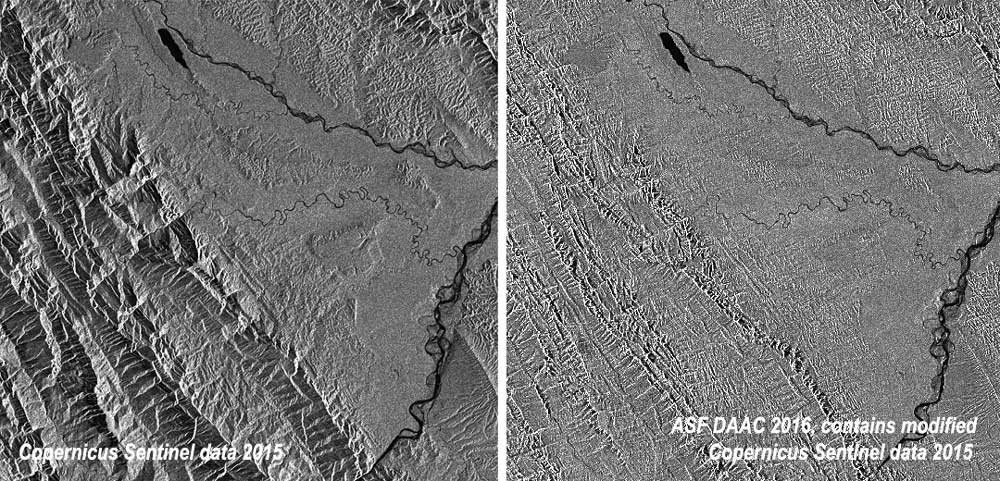

image from https://asf.alaska.edu/how-to/data-recipes/how-to-radiometrically-terrain-correct-rtc-sentinel-1-data-using-s1tbx-script/

Unfortunately, RTC does not fix layover or radar shadow. **To mitigate radar shadow, we remove all pixels with incidence angle >70°.** As of yet, there is no masking of layover in the data, so be wary of potentially inaccurate results in front of steep slopes. 

#### Radar backscatter
Sentinel-1 measures the amplitude of backscatter returned from the target surface, which is converted into decibels before the snow depth algorithm is implemented. Co-polarized backscatter maintains its polarization during interaction with the surface, while cross-polarized backscatter changes its polarization during interaction with the surface. The interaction of the radar signal with the snow surface is poorly understood. Lievens et al. (2022) has the following to say: 

*"At C-band, co-polarized backscatter is generally dominated by (i) the scattering from the ground surface (depending on the moisture content and the temperature or freeze–thaw state of the soil) in dry snow conditions or by (ii) the absorption by liquid water in wet snow conditions (Baghdadi et al., 1997; Nagler and Roth, 2000; Luojus et al., 2007; Nagler et al., 2016).*

*Although further research is needed to improve our basic understanding of the physical scattering mechanisms, we hypothesize that cross-polarized observations at C-band are more sensitive to dry snow accumulation than co-polarized observations for two main reasons. First, the surface scattering from the ground is significantly weaker in cross-polarization due to the limited depolarization that occurs at the ground surface, especially for smooth surfaces. Second, dry snow is expected to enhance scattering in cross-polarization. More specifically, dry snow represents a multi-layered, dense medium of irregularly shaped (anisotropic) ice crystals that can form larger-scale clusters. Enhanced signal depolarization can for instance occur due to scattering within the dense anisotropic snow volume, multiple scattering on snow layer interfaces, and snow–ground scattering interactions (Du et al., 2010; Chang et al., 2014; Leinss et al., 2016). Hence, in cross-polarized observations, the scattering from the ground surface may no longer dominate over the scattering from the snow (Shi and Dozier, 2000; Pivot, 2012), especially for deep snow that is often encountered in mountain regions."*

This hypothesis has some big implications for how we should apply and interpret methods to derive Sentinel-1 snow depth from C-band radar observations. Namely, we can expect:
- **improved accuracy in deep, dry snow, which depolarizes and scatters the radar signal**
- **significantly reduced accuracy in wet snow, which strongly absorbs the radar signal**

## How does the snow depth retrieval algorithm work?
The following is a conceptual summary of how the algorithm works. To read a full description, please refer to Lievens et al. (2022). For a given RTC Sentinel-1 scene, we perform the following at each pixel: 

1. Calculate a "cross-polarization ratio" between co-polarized and cross-polarized backscatter. The cross-polarization ratio seems to be more related to snow-depth in open areas, while the co-polarized backscatter seems to be more related to snow depth in vegetated areas. An empirically-derived constant, 'A', is used to weight the contribution of cross-polarized backscatter to the ratio. 
2. Calculate the change in co-polarized backscatter and in cross-polarization ratio since the last acquisition from the same relative orbit. These changes contain some information about change in snow depth. 
3. Scale the changes in cross-polarization ratio and in co-polarized backscatter by the fractional forest cover, then sum them. The change in cross-polarization ratio is weighted more heavily in open areas, while the change in co-polarized backscatter is weighted more heavily in vegetated areas. An empirically-derived constant, 'B' is also used to weight the contribution of co-polarized backscatter. 
4. Calculate the 'snow change detection index' by adding the sum from step 3 to the prior snow change detection index. The prior snow change detection index is actually a weighted sum of snow change detection indices from Sentinel-1 acquisitions in the previous five days (regardless of relative orbit) where more recent acquisitions are weighted more heavily. The important thing to understand here is that in this step we're accumulating change in snow depth over time. 
5. The snow change detection index is set to zero if 1) the snow extent mask indicates that there's no snow at the pixel or 2) the snow change index is negative. 
6. Multiply the snow accumulation index by an empirically-derived constant, 'C', to convert it to snow depth in meters. 

This algorithm is based on the hypotheses about backscatter in snow depth described above, but it's only loosely physical--especially in the way that snow depth is removed. Also, it relies on three empirically-derived constants, which are ideally optimized to the site where the algorithm is applied. 
#### Wet snow
Liquid water in wet snow strongly absorbs the C-band signal, reducing the strength of the returns and probably decreasing the accuracy of the snow depth algorithm. As a result some method is needed to determine whether a given pixel contains wet snow, in which case we should be very skeptical of the predicted snow depth. This is primarily accomplished by flagging pixels with low returns using a threshold (Lievens et al., 2022). At the moment, spicy-snow doesn't actually mask wet pixels, but it does flag them. Users may decide to mask wet pixels themselves. Also please note that we've found that the current threshold  (-2 dB) is aggressive and prone to false positives. 

## How does spicy-snow implement the snow depth retrieval algorithm?
The snow depth retrieval algorithm requires three ingredients: a time series of RTC Sentinel-1 scenes, a fractional forest cover product, and a snow extent time series product. In general, spicy-snow is implemented to match the method described in Lievens et al. (2022) as closely as possible. 
#### RTC products
spicy-snow only requires the user to provide a bounding box and a date range. We use the Alaska Satellite Facility's (ASF) HyP3 on-demand processing to generate the RTC products used to calculate snow depth (https://hyp3-docs.asf.alaska.edu/). ASF HyP3 uses the 2021 release of the 30 m Copernicus “GLO30” digital elevation model DEM product to perform the terrain correction (https://registry.opendata.aws/copernicus-dem/). Users will need an Earthdata username and password to make use of this free (for now) service. Note that each user has a quota of 1000 jobs per month. RTC products are output at 30 m pixel spacing and upsampled in order to increase the signal-to-noise ratio. Current default pixel spacing of spicy-snow snow depth maps is 90 m. 
#### Fractional forest cover products
For fractional forest cover, spicy-snow uses the the Copernicus Global Land Service Land Cover 100 m dataset for 2019, which is derived from PROBA-V satellite observations (https://zenodo.org/record/3939050). The product pixel spacing is rescaled to match the spicy-snow output pixel spacing. Note that if spatial distribution of forest cover is significantly different during your period of interest than it was in 2019 (for example, if a forest was clear-cut), accuracy of spicy-snow snow depth maps may be reduced. 
#### Snow extent products
For snow extent, spicy-snow uses the U.S. National Ice Center (USNIC) Interactive Multisensor Snow and Ice Mapping System (IMS) data product at 1 km spatial resolution and 24 hour temporal resolution (https://usicecenter.gov/Products/ImsHome). The product pixel spacing is rescaled to match the spicy-snow output pixel spacing, but note that the product resolution is significantly lower than the current default spicy-snow output resolution, which can result in ~1 km artifacts in snow depth maps.
#### Computing considerations
spicy-snow can consume a significan amount of RAM during processing, depending on the size of the area of interest and the length of the period of interest. For example, ~20 G is needed to process one year for a ~125 square km area.

## Should I use spicy-snow to get snow depths for my site?
We hope that you do! Just remember that this snow-depth retrieval algorithm probably works best where snow is deep and dry, forest cover is limited, and terrain isn't too steep. Comparison with in-situ snow depth data is a good idea (see 04analysis notebook). 

## Additional Resources
- Project link https://github.com/SnowEx/spicy-snow
- Lievens et al. (2022) paper https://tc.copernicus.org/articles/16/159/2022/
- Lievens et al. (2019) paper https://www.nature.com/articles/s41467-019-12566-y
- SAR basics https://asf.alaska.edu/information/sar-information/what-is-sar/
- More SAR basics https://www.earthdata.nasa.gov/learn/backgrounders/what-is-sar
- Sentinel-1 SAR https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar
- More on ASF HyP3 RTC: https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/
- SAR theory from 2022 UNAVCO InSAR class (more advanced) https://nbviewer.org/github/parosen/Geo-SInC/blob/main/UNAVCO2022/0.8_SAR_Theory_Phenomenology/SAR.ipynb, https://nbviewer.org/github/parosen/Geo-SInC/blob/main/UNAVCO2022/0.9_SAR_Imaging_Theory/SAR_Processor.ipynb

## References
Baghdadi, N., Gauthier, Y., & Bernier, M. (1997). Capability of multitemporal ERS-1 SAR data for wet-snow mapping. Remote sensing of environment, 60(2), 174-186.

Chang, W., Tan, S., Lemmetyinen, J., Tsang, L., Xu, X., & Yueh, S. H. (2014). Dense media radiative transfer applied to SnowScat and SnowSAR. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 7(9), 3811-3825.

Du, J., Shi, J., & Rott, H. (2010). Comparison between a multi-scattering and multi-layer snow scattering model and its parameterized snow backscattering model. Remote Sensing of Environment, 114(5), 1089-1098.

Leinss, S., Löwe, H., Proksch, M., Lemmetyinen, J., Wiesmann, A., & Hajnsek, I. (2016). Anisotropy of seasonal snow measured by polarimetric phase differences in radar time series. The Cryosphere, 10(4), 1771-1797.

Luojus, K. P., Pulliainen, J. T., Metsamaki, S. J., & Hallikainen, M. T. (2007). Snow-covered area estimation using satellite radar wide-swath images. IEEE transactions on geoscience and remote sensing, 45(4), 978-989.

Nagler, T., & Rott, H. (2000). Retrieval of wet snow by means of multitemporal SAR data. IEEE Transactions on Geoscience and Remote Sensing, 38(2), 754-765.

Nagler, T., Rott, H., Ripper, E., Bippus, G., & Hetzenecker, M. (2016). Advancements for snowmelt monitoring by means of Sentinel-1 SAR. Remote Sensing, 8(4), 348.

Pivot, F. C. (2012). C-band SAR imagery for snow-cover monitoring at Treeline, Churchill, Manitoba, Canada. Remote Sensing, 4(7), 2133-2155.

Pouya, S., & Aghlmand, M. (2022). Evaluation of urban green space per capita with new remote sensing and geographic information system techniques and the importance of urban green space during the COVID-19 pandemic. Environmental Monitoring and Assessment, 194(9), 633.

Shi, J., & Dozier, J. (2000). Estimation of snow water equivalence using SIR-C/X-SAR. II. Inferring snow depth and particle size. IEEE Transactions on Geoscience and Remote sensing, 38(6), 2475-2488.

Small, D. (2011). Flattening gamma: Radiometric terrain correction for SAR imagery. IEEE Transactions on Geoscience and Remote Sensing, 49(8), 3081-3093.